In [1]:
!pip install wandb

In [2]:
import torch
from torch import nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import cv2
from torchvision import datasets, transforms
import wandb
from torch.utils.data import DataLoader
import tqdm

In [3]:
wandb.init(
    # set the wandb project where this run will be logged
    project="marble-anomaly-detection",

    # track hyperparameters and run metadata
    config={
    "learning_rate": "3e-4",
    "architecture": "Autoencoder",
    "dataset": "https://www.kaggle.com/datasets/wardaddy24/marble-surface-anomaly-detection-2",
    "epochs": 10,
    }
)

wandb: Currently logged in as: aaryadev. Use `wandb login --relogin` to force relogin


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!unzip /content/drive/MyDrive/learning\ machine\ learning/marble2.zip

Archive:  /content/drive/MyDrive/learning machine learning/marble2.zip
replace marble2/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


### Convolutional Autoencoder Network Definition

In [6]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, kernel_size=7)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=7),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        batch_size = x.shape[0]
        x = self.encoder(x)
        x = self.decoder(x)

        return x.reshape(batch_size, -1)


In [7]:
ae = Autoencoder()

In [8]:
loss_fn = nn.MSELoss() # l2 norm loss
optimizer = torch.optim.Adam(ae.parameters(), lr=3e-4)

In [9]:
# converting images to tensors, and normalizing for better gradient flow
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)]
)

### Creating dataset with good marble samples and loading it for batch training

In [10]:
train_dataset = datasets.ImageFolder('./marble2/train/', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [11]:
epochs = 10
for _ in tqdm.tqdm(range(epochs)):
    epoch_loss = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        loss = loss_fn(ae(inputs), inputs.reshape(inputs.shape[0], -1))
        wandb.log({"loss": loss})
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        epoch_loss += loss
    epoch_loss /= train_loader.batch_size

100%|██████████| 10/10 [00:48<00:00,  4.82s/it]


### Loading anomalous marbles dataset

In [12]:
test_dataset = datasets.ImageFolder('./marble2/test/', transform=transform)

In [13]:
# checking integrity of first sample by probing shape
test_dataset[0][0].shape

torch.Size([3, 256, 256])

### Testing reconstruction loss value on a single anomalous sample

In [14]:
# The reconstruction loss we achieve on a defective marble piece is an order of magnitude higher
# than a good sample
loss_fn(ae(test_dataset[0][0].reshape(1, 3, 256, 256)), test_dataset[0][0].reshape(1, -1))

tensor(0.0774, grad_fn=<MseLossBackward0>)

## Calculating average reconstruction loss for good samples and anomalies

In [15]:
train_losses = []
test_losses = []
for i in range(len(train_dataset)):
  # calculating loss for each defective marble sample
  test_loss = loss_fn(ae(test_dataset[i][0].reshape(1, 3, 256, 256)), test_dataset[i][0].reshape(1, -1))
  test_losses.append(test_loss)

  # calculating loss for each good marble sample
  train_loss = loss_fn(ae(train_dataset[i][0].reshape(1, 3, 256, 256)), train_dataset[i][0].reshape(1, -1))
  train_losses.append(train_loss)


In [16]:
# converting losses to numpy arrays since
# since list of tensors cannot be plotted
train_losses2 = [loss.detach().numpy() for loss in train_losses]
test_losses2 = [loss.detach().numpy() for loss in test_losses]

In [17]:
# average reconstruction loss for a good marble
np.mean(train_losses2)

0.0029177903

In [18]:
# average reconstruction loss for an anomalous marble
np.mean(test_losses2)

0.035457544

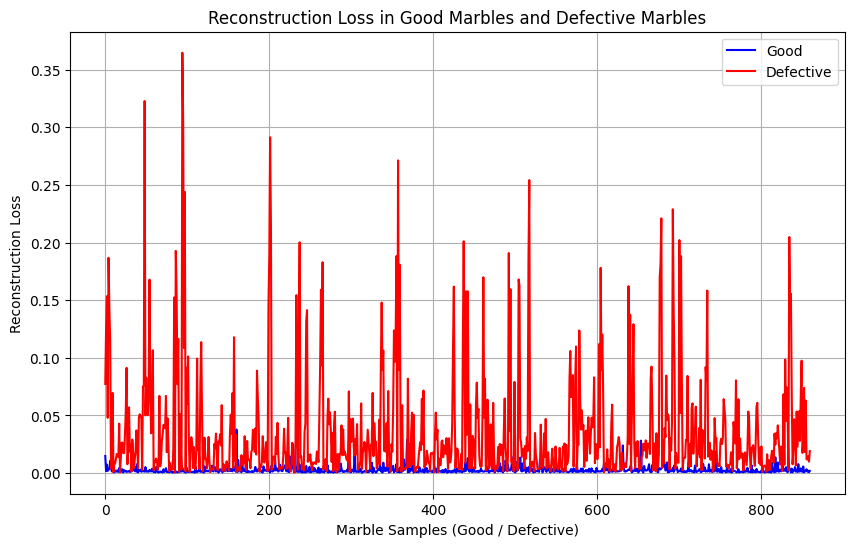

In [19]:
# plotting reconstruction loss for good and defective marbles on the same plot for convenience
plt.figure(figsize=(10, 6))

plt.plot(train_losses2, label='Good', color='blue')
plt.plot(test_losses2, label='Defective', color='red')

plt.title('Reconstruction Loss in Good Marbles and Defective Marbles')
plt.xlabel('Marble Samples (Good / Defective)')
plt.ylabel('Reconstruction Loss')

plt.legend()
plt.grid()
plt.show()
